In [57]:
import sklearn
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
import time

In [6]:
filename = 'train.csv'
df_train = pd.read_csv(filename, index_col='id')
df_train.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [43]:
X, y = df_train['text'], df_train['author']
X_train, X_dev, Y_dev, Y_dev = train_test_split(X, y, test_size=0.2, random_state=707)

In [44]:
classes = list(df_train['author'].unique())
classes

['EAP', 'HPL', 'MWS']

In [45]:
encoder = preprocessing.LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_dev = encoder.fit_transform(Y_dev)

In [46]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [47]:
def train_model(classifier, train_vectors, train_labels, valid_vectors, Y_dev, is_neural_net=False):
    classifier.fit(train_vectors, train_labels)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(valid_vectors)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, Y_dev)

In [48]:
def show_cm(classifier, train_vectors, train_labels, valid_vectors, Y_dev):
    classifier.fit(train_vectors, train_labels)
    predictions = classifier.predict(valid_vectors)
    return plot_confusion_matrix(Y_dev, predictions, classes, normalize=True, cmap=plt.cm.Blues)

In [49]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)
X_train_count =  count_vect.transform(X_train)
X_dev_count =  count_vect.transform(X_dev)

In [50]:
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_count, Y_train, X_dev_count, Y_dev)
print("NB, Count Vectors: ", accuracy)

NB, Count Vectors:  0.8444841675178754


In [52]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_dev_tfidf =  tfidf_vect.transform(X_dev)

In [53]:
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, Y_train, X_dev_tfidf, Y_dev)
print("NB, Word-Level TF-IDF: ", accuracy)

NB, Word-Level TF-IDF:  0.806435137895812


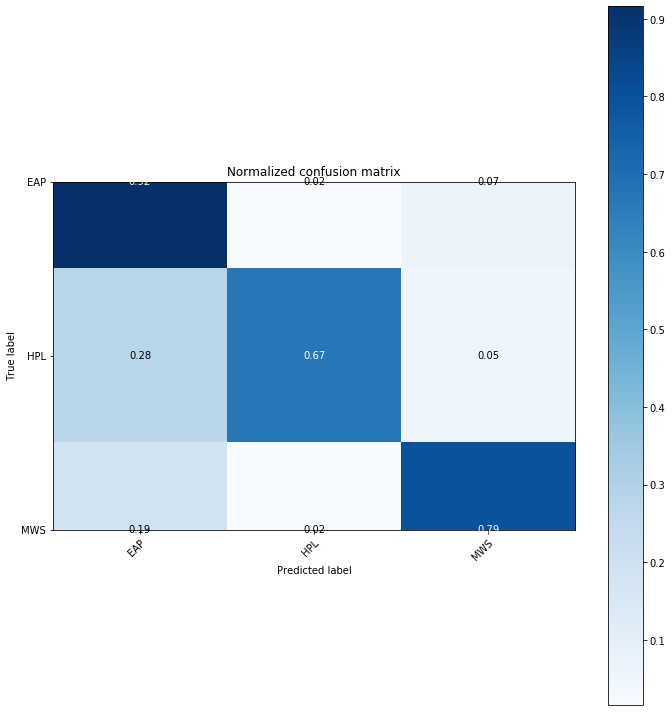

In [56]:
cm = show_cm(naive_bayes.MultinomialNB(), X_train_tfidf, Y_train, X_dev_tfidf, Y_dev)
plt.show()

In [62]:
num_chars = [(i,i) for i in range(11)]
# character level tf-idf
for i, num in enumerate(num_chars):
    print("num_chars = ", i+1)
    start = time.time()
    tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=num)
    tfidf_vect_ngram_chars.fit(X_train)
    X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
    X_dev_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_dev)
    accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_chars, Y_train, X_dev_tfidf_ngram_chars, Y_dev)
    print("NB, Char-Level TF-IDF with num_chars = ", i+1, ": ", accuracy, "time taken: ", time.time()-start)

num_chars =  1
NB, Char-Level TF-IDF with num_chars =  1 :  0.3924923391215526 time taken:  1.0611984729766846
num_chars =  2
NB, Char-Level TF-IDF with num_chars =  2 :  0.3924923391215526 time taken:  0.7844693660736084
num_chars =  3
NB, Char-Level TF-IDF with num_chars =  3 :  0.599591419816139 time taken:  1.813112497329712
num_chars =  4
NB, Char-Level TF-IDF with num_chars =  4 :  0.7415730337078652 time taken:  2.0833637714385986
num_chars =  5
NB, Char-Level TF-IDF with num_chars =  5 :  0.77170582226762 time taken:  2.299219846725464
num_chars =  6
NB, Char-Level TF-IDF with num_chars =  6 :  0.7625127681307456 time taken:  2.660482406616211
num_chars =  7
NB, Char-Level TF-IDF with num_chars =  7 :  0.7469356486210419 time taken:  3.3272862434387207
num_chars =  8
NB, Char-Level TF-IDF with num_chars =  8 :  0.7328907048008172 time taken:  4.319595098495483
num_chars =  9
NB, Char-Level TF-IDF with num_chars =  9 :  0.7219101123595506 time taken:  5.307505130767822
num_chars

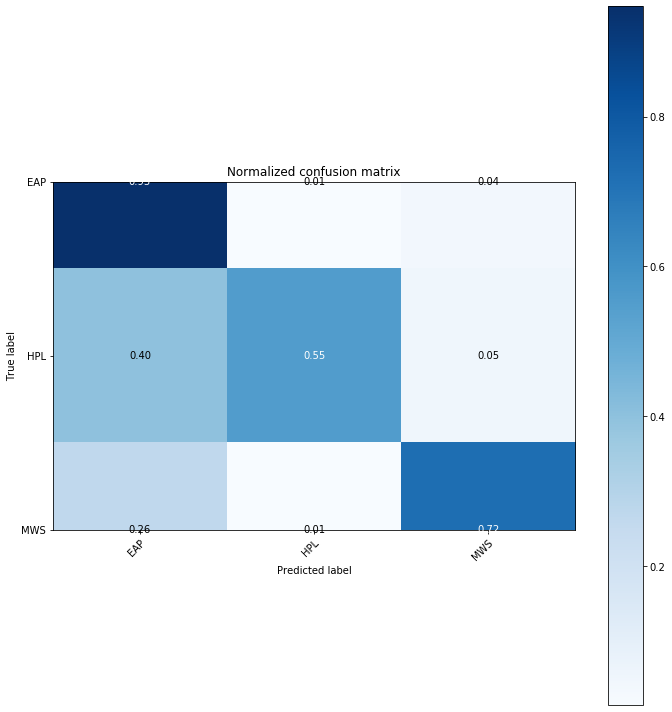

In [59]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train_tfidf_ngram_chars, Y_train)
predictions = classifier.predict(X_dev_tfidf_ngram_chars)
sklearn.metrics.confusion_matrix (Y_dev, predictions, labels=None, sample_weight=None)
cm = plot_confusion_matrix(Y_dev, predictions, classes, normalize=True, cmap=plt.cm.Blues)

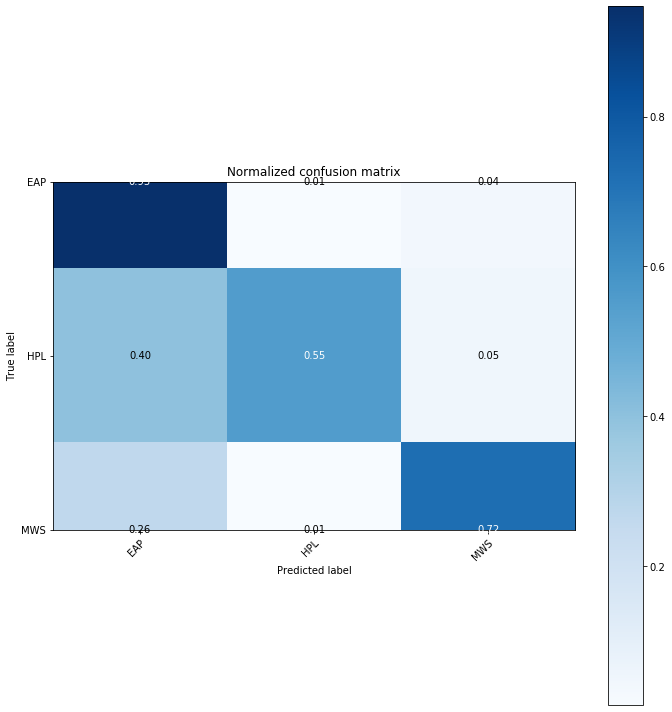

In [61]:
cm = plot_confusion_matrix(Y_dev, predictions, classes, normalize=True, cmap=plt.cm.Blues)

In [64]:
df_train.shape

(19579, 2)

In [80]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%Y-%m-%d-%H:%M")
print("Current Time =", current_time)

Current Time = 2020-01-01-15:01
